# Modeling

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

# statistics testing
import scipy.stats as stats

# system manipulation
import itertools
import os
import sys
sys.path.append("./util_")
import prepare_
import explore_

# other
import env
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)

**Get train and validate datasets**

In [2]:
# This data is already been split and save
# This is only training data
train_scaled = pd.read_csv("./00_project_data/1-1_training_data.csv", index_col=0)
validate_scaled = pd.read_csv("./00_project_data/1-2_validation_data.csv", index_col=0)

train_scaled = train_scaled.reset_index(drop=True)
validate_scaled = validate_scaled.reset_index(drop=True)
train_scaled.head()

,tax_value,county,los_angeles,orange,ventura,bedrooms_scaled,bathrooms_scaled,sqr_feet_scaled,year_built_scaled,tax_amount_scaled
0,385794.0,Los Angeles,1,0,0,0.75,0.444444,0.199454,0.424528,0.248709
1,206832.0,Los Angeles,1,0,0,0.50,0.222222,0.141558,0.283019,0.138462
2,526078.0,Ventura,0,0,1,0.75,0.444444,0.457108,0.424528,0.276061
3,468240.0,Los Angeles,1,0,0,0.75,0.666667,0.526523,0.424528,0.268749
4,270136.0,Orange,0,1,0,1.00,0.444444,0.239770,0.518868,0.158247


**Separate Feature and target**

In [3]:
# separate features from target
# these coluns are set in order of importance
xtrain = train_scaled[['los_angeles', 'ventura', "orange",
                       'bathrooms_scaled','sqr_feet_scaled', "bedrooms_scaled", "year_built_scaled"]]

ytrain= train_scaled.tax_value

### ----------------------------------------------------------------

# separate features from target
# these coluns are set in order of importance
xval = validate_scaled[['los_angeles', 'ventura', "orange",
                       'bathrooms_scaled','sqr_feet_scaled', "bedrooms_scaled", "year_built_scaled"]]

yval= validate_scaled.tax_value


**Set baseline**

In [4]:
# create a temporary dataframe for the baseline
base = pd.DataFrame({
    "mean_baseline": np.arange(len(train_scaled)),
    "median_baseline": np.arange(len(train_scaled))
})

# get the baseline averages
mean_base = train_scaled.tax_value.mean()
median_base = train_scaled.tax_value.median()

# add the averages into the dataframe
base.mean_baseline = mean_base
base.median_baseline = median_base

# compute the RMSE baseline
# set baseline at the mean and median of the target
baseline_mean = mean_squared_error(ytrain,base.mean_baseline) ** (0.5)
baseline_median = mean_squared_error(ytrain, base.median_baseline) ** (0.5)

print(f"mean basline: {baseline_mean}\
\nmedian baseline: {baseline_median}")

mean basline: 212157.49658660826
median baseline: 215487.63907708594


## Linear Regression (OLS)

**Train**

In [5]:
# MAKE THE THING: create the model object
linear_model_ols = LinearRegression(fit_intercept=True)

#1. FIT THE THING: fit the model to training data
OLSmodel = linear_model_ols.fit(xtrain, ytrain)

#2. USE THE THING: make a prediction
ytrain_pred_ols = linear_model_ols.predict(xtrain)

#3. Evaluate: RMSE
rmse_train_ols = mean_squared_error(ytrain, ytrain_pred_ols) ** (.5) # 0.5 to get the root


**Validate**

In [6]:

#2. USE THE THING: make a prediction
yval_pred_ols = linear_model_ols.predict(xval)

#3. Evaluate: RMSE
rmse_val_ols = mean_squared_error(yval, yval_pred_ols) ** (.5) # 0.5 to get the root


# root mean squeared error
print(f"""RMSE for OLS
_____________________
OLS Regressor \nRMSE_train {rmse_train_ols}
RMSE_validate {rmse_val_ols}
RMSE_difference {rmse_val_ols - rmse_train_ols}
Difference from baseline:  {rmse_val_ols - baseline_mean}
______________________
R2_validate {explained_variance_score(yval, yval_pred_ols)}")

Looking for:
High R^2
Low RMSE
High RMSE difference baseline
Low RMSE difference between training and validation
""")

# Create a DataFrame with a single row
data = {'RMSE Training': rmse_train_ols,
        'RMSE Validation': rmse_val_ols, 
        'train validate RMSE diff': rmse_val_ols - rmse_train_ols,
       'val baseline diff': rmse_val_ols - baseline_mean,
       'R2_validate': explained_variance_score(yval, yval_pred_ols)}
results = pd.DataFrame([data])
results

RMSE for OLS
_____________________
OLS Regressor 
RMSE_train 187043.68279436068
RMSE_validate 187376.12178418814
RMSE_difference 332.4389898274676
Difference from baseline:  -24781.37480242012
______________________
R2_validate 0.2233121229584737")

Looking for:
High R^2
Low RMSE
High RMSE difference baseline
Low RMSE difference between training and validation



,RMSE Training,RMSE Validation,train validate RMSE diff,val baseline diff,R2_validate
0,187043.682794,187376.121784,332.43899,-24781.374802,0.223312


## LassoLars

**train**

In [7]:
# MAKE THE THING: create the model object
linear_nodel_lars = LassoLars(alpha= 1.0, fit_intercept=False, max_iter=1000)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
laslars = linear_nodel_lars.fit(xtrain, ytrain)

#2. USE THE THING: make a prediction
ytrain_pred_lars = linear_nodel_lars.predict(xtrain)

#3. Evaluate: RMSE
rmse_train_lars = mean_squared_error(ytrain, ytrain_pred_lars) ** (0.5)


**Validate**

In [8]:

# predict validate
yval_pred_lars = linear_nodel_lars.predict(xval)

# evaluate: RMSE
rmse_val_lars = mean_squared_error(yval, yval_pred_lars) ** (0.5)

# how important is each feature to the target
laslars.coef_

print(f"""RMSE for Lasso + Lars
_____________________
RMSE Training/In-Sample: {rmse_train_lars}, 
RMSE Validation/Out-of-Sample:  {rmse_val_lars}
RMSE Difference:  {rmse_val_lars - rmse_train_lars}
Difference from baseline:  {rmse_val_lars - baseline_mean}
______________________
R2_validate {explained_variance_score(yval, yval_pred_lars)}")

Looking for:
High R^2
Low RMSE
High RMSE difference baseline
Low RMSE difference between training and validation
""")

# Create a DataFrame with a single row
data = {'RMSE Training': rmse_train_lars,
        'RMSE Validation': rmse_val_lars, 
        'train validate RMSE diff': rmse_val_lars - rmse_train_lars,
       'val baseline diff': rmse_val_lars - baseline_mean,
       'R2_validate': explained_variance_score(yval, yval_pred_lars)}
results = pd.DataFrame([data])
results

RMSE for Lasso + Lars
_____________________
RMSE Training/In-Sample: 187043.6482554098, 
RMSE Validation/Out-of-Sample:  187376.6049225882
RMSE Difference:  332.95666717839777
Difference from baseline:  -24780.891664020077
______________________
R2_validate 0.22330816171738843")

Looking for:
High R^2
Low RMSE
High RMSE difference baseline
Low RMSE difference between training and validation



,RMSE Training,RMSE Validation,train validate RMSE diff,val baseline diff,R2_validate
0,187043.648255,187376.604923,332.956667,-24780.891664,0.223308


## TweedieRegressor (GLM:Generalized Linear Model)

<Axes: >

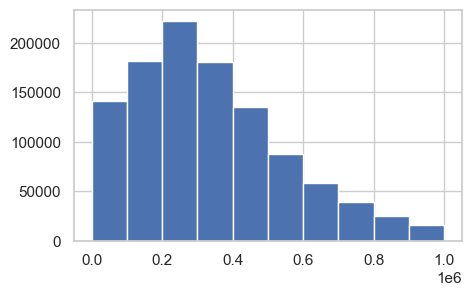

In [9]:
# Plot the distribution
plt.figure(figsize=(5,3))
ytrain.hist()

# looks like a gamma distribution

**Train**

In [10]:
# MAKE THE THING: create the model object
linear_nodel_twd = TweedieRegressor(alpha= 1.0, power= 1)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
tweedieReg = linear_nodel_twd.fit(xtrain, ytrain)

#2. USE THE THING: make a prediction
ytrain_pred_twd = linear_nodel_twd.predict(xtrain)

#3. Evaluate: RMSE
rmse_train_twd = mean_squared_error(ytrain, ytrain_pred_twd) ** (0.5)


**Validate**

In [11]:
# predict validate
yval_pred_twd = linear_nodel_twd.predict(xval)

# evaluate: RMSE
rmse_val_twd = mean_squared_error(yval, yval_pred_twd) ** (0.5)

# how important is each feature to the target
tweedieReg.coef_

print(f"""RMSE for Tweedie Regressor
_____________________
RMSE Training/In-Sample: {rmse_train_twd}, 
RMSE Validation/Out-of-Sample:  {rmse_val_twd}
RMSE Difference:  {rmse_val_twd - rmse_train_twd}
Difference from baseline:  {rmse_val_twd - baseline_mean}
______________________
R2_validate {explained_variance_score(yval, yval_pred_twd)}")

Looking for:
High R^2
Low RMSE
High RMSE difference baseline
Low RMSE difference between training and validation
""")

# Create a DataFrame with a single row
data = {'RMSE Training': rmse_train_twd,
        'RMSE Validation': rmse_val_twd, 
        'train validate RMSE diff': rmse_val_twd - rmse_train_twd,
       'val baseline diff': rmse_val_twd - baseline_mean,
       'R2_validate': explained_variance_score(yval, yval_pred_twd)}
results = pd.DataFrame([data])


RMSE for Tweedie Regressor
_____________________
RMSE Training/In-Sample: 187251.25075231143, 
RMSE Validation/Out-of-Sample:  187565.82390969963
RMSE Difference:  314.57315738819307
Difference from baseline:  -24591.672676908638
______________________
R2_validate 0.2217387012794404")

Looking for:
High R^2
Low RMSE
High RMSE difference baseline
Low RMSE difference between training and validation



## Polynomial Features

**Prep Polynomial features**

In [18]:
#1. Create the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3) #Quadratic aka x-squared

#1. Fit and transform X_train_scaled
xtrain_degree3 = pf.fit_transform(xtrain)

#1. Transform X_validate_scaled & X_test_scaled 
xval_degree3 = pf.transform(xval)

xtrain_degree2[1]

array([1.        , 1.        , 0.        , 0.        , 0.22222222,
       0.14155805, 0.5       , 0.28301887, 1.        , 0.        ,
       0.        , 0.22222222, 0.14155805, 0.5       , 0.28301887,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04938272, 0.03145734, 0.11111111, 0.06289308,
       0.02003868, 0.07077902, 0.0400636 , 0.25      , 0.14150943,
       0.08009968, 1.        , 0.        , 0.        , 0.22222222,
       0.14155805, 0.5       , 0.28301887, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04938272,
       0.03145734, 0.11111111, 0.06289308, 0.02003868, 0.07077902,
       0.0400636 , 0.25      , 0.14150943, 0.08009968, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

**Train**

In [19]:
#2.1 MAKE THE THING: create the model object
linear_model_pf = LinearRegression()

#2.2 FIT THE THING: fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
polyFeat = linear_model_pf.fit(xtrain_degree3, ytrain)

#3. USE THE THING: predict train
ytrain_pred_poly = linear_model_pf.predict(xtrain_degree3)

#4. Evaluate: rmse
rmse_train_poly = mean_squared_error(ytrain, ytrain_pred_poly) ** (0.5)


**Validate**

In [14]:
# predict validate
yval_pred_poly = linear_model_pf.predict(xval_degree2)

# evaluate: RMSE
rmse_val_poly = mean_squared_error(yval, yval_pred_poly) ** (0.5)

# how important is each feature to the target
polyFeat.coef_


print(f"""Polynomial feature regressor
_____________________
RMSE Training/In-Sample: {rmse_train_poly}, 
RMSE Validation/Out-of-Sample:  {rmse_val_poly}
RMSE Difference:  {rmse_val_poly - rmse_train_poly}
Difference from baseline:  {rmse_val_poly - baseline_mean}
______________________
R2_validate {explained_variance_score(yval, yval_pred_poly)}")

Looking for:
High R^2
Low RMSE
High RMSE difference baseline
Low RMSE difference between training and validation
""")

# Create a DataFrame with a single row
data = {'RMSE Training': rmse_train_poly,
        'RMSE Validation': rmse_val_poly, 
        'train validate RMSE diff': rmse_val_poly - rmse_train_poly,
       'val baseline diff': rmse_val_poly - baseline_mean,
       'R2_validate': explained_variance_score(yval, yval_pred_poly)}
results = pd.DataFrame([data])
results

Polynomial feature regressor
_____________________
RMSE Training/In-Sample: 183837.83233884265, 
RMSE Validation/Out-of-Sample:  184170.37466070065
RMSE Difference:  332.5423218579963
Difference from baseline:  -27987.121925907617
______________________
R2_validate 0.2496604225061292")

Looking for:
High R^2
Low RMSE
High RMSE difference baseline
Low RMSE difference between training and validation



,RMSE Training,RMSE Validation,train validate RMSE diff,val baseline diff,R2_validate
0,183837.832339,184170.374661,332.542322,-27987.121926,0.24966


## Best Model Test (GML)

In [27]:
# This is only the test data
test_scaled = pd.read_csv("./00_project_data/1-3_testing_data.csv", index_col=0)

test_scaled = test_scaled.reset_index(drop=True)

# separate features from target
# these coluns are set in order of importance
xtest = test_scaled[['los_angeles', 'ventura', 'orange', 
                       'bathrooms_scaled','sqr_feet_scaled', 
                       'bedrooms_scaled', 'year_built_scaled']]

ytest= test_scaled.tax_value

In [26]:
# predict validate
ytest_pred_twd = linear_nodel_twd.predict(xtest)

# evaluate: RMSE
rmse_test_twd = mean_squared_error(ytest, ytest_pred_twd) ** (0.5)

# how important is each feature to the target
tweedieReg.coef_

print(f"""RMSE for Tweedie Regressor
_____________________
RMSE Training/In-Sample: {rmse_train_twd}, 
RMSE Validation/Out-of-Sample:  {rmse_test_twd}
RMSE Difference:  {rmse_test_twd - rmse_train_twd}
Difference from baseline:  {rmse_test_twd - baseline_mean}
______________________
R2 validate {explained_variance_score(yval, yval_pred_twd)}")
""")

data = {'RMSE Training': rmse_train_twd,
            'RMSE test': rmse_test_twd,
            'RMSE baseline': baseline_mean,
            'train test RMSE diff': rmse_test_twd - rmse_train_twd,
        'test baseline diff': rmse_test_twd - baseline_mean,
        'R2 test': explained_variance_score(ytest, ytest_pred_twd)}
results = pd.DataFrame([data])
results

RMSE for Tweedie Regressor
_____________________
RMSE Training/In-Sample: 187251.25075231143, 
RMSE Validation/Out-of-Sample:  187507.5941606917
RMSE Difference:  256.34340838025673
Difference from baseline:  -24649.902425916574
______________________
R2 validate 0.2217387012794404")



,RMSE Training,RMSE test,RMSE baseline,train test RMSE diff,test baseline diff,R2 test
0,187251.250752,187507.594161,212157.496587,256.343408,-24649.902426,0.222059
